# Homework 3  - Part B


###### Roll Number:

We'll start Part B by taking out a minute to thank creators of Tensorflow and Keras for making our lives easier. The goal of this home work is to design a convolutional neural network to classify images from CIFAR-10. CIFAR-10 is a subset of CIFAR-100 with 10 and 100 being number of classes. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. We'll be building small CNNs using Keras to solve this classification task.
<br>

Please note:
- You have to save each trained model weights and tensorboard logs in different folder. Use proper names for the model
- You have to show trainings in this notebook file, so make sure that the printings and figures are available on this notebook file
- This notebook is also your report file. So add your comments and analysis of each task. Your comments and analysis are as important as your code. This would be considered short report and it is compulsory part of the homework.
- Your system memory may overflow. In that case, please reset memory for trained model(s) keeping printed logs and history of trained model. History of all trained models could be used to plot the trends.
- For trends you shall also use tensorboard logs 

### Imports

In [0]:
import keras
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau, TensorBoard
from keras.utils import plot_model, to_categorical
import keras.backend as K

from sklearn.model_selection import train_test_split
from IPython.display import display

import cv2
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import os
import glob
import shutil
%cd ../
your_id = 20100064
np.random.seed(your_id)

Using TensorFlow backend.


/


###### Hyperparameters

In [0]:
batch_size = 64
num_classes = 10
class_labels = np.arange(0, num_classes, 1)
input_shape_cifar = (32,32,3)
images_dir = './images/cifar/'
epochs = 25
all_histories = []

### Task 1.1   Load dataset information
Download the [CIFAR-10 Dataset](https://drive.google.com/drive/folders/1FPsts3C2tJMVQ1xcCi2XZdb2z_J2OjSr?usp=sharing) and setup your working directory. Be sure to put the dataset in the <code>images_dir</code> directory. We won't be loading images and will only store the file paths in memory. These file paths will be used to load and return batch of images in our generator. Feel free to explore the dataset in this section.

In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd ../content

/content


In [0]:
os.mkdir("images")

In [0]:
shutil.copy2('drive/My Drive/cifar.zip', 'images/cifar.zip')
#!unzip"/content/images/cifar.zip"

'images/cifar.zip'

In [0]:
%cd ../content/images
#!unzip "cifar.zip"

/content/images


In [0]:
!unzip "cifar.zip"

In [0]:
%cd ../

/content


In [0]:
train_dir = images_dir + 'train/'
test_dir = images_dir + 'test/'
label_dir = images_dir + 'labels.txt'

# Use either os.listdir or glob to generate an array of file paths for training and testing data (I would recommend using glob)
lstrain = os.listdir(train_dir)
train_files = []
for x in lstrain:
  train_files.append(os.path.join(train_dir,x))

lstest = os.listdir(test_dir)
test_files = []
for x in lstest:
  test_files.append(os.path.join(test_dir,x))

# Use labels.txt to store labels in an array/dict (NOTE: The line number corresponds to the actual label)
classes = []
i = 0
with open(label_dir) as f:
    classes = f.read().split()

# Use sci-kit learn's train_test_split method to generate a validation dataset from the training dataset
_ , val_files = train_test_split(train_files,test_size = 0.2)

### Task 1.2 Preprocessing
Preprocessing of data such as normalization, mean shift, make the learning task simple for network and could accelerate the training process. 

###### Task 1.2.1 
In images, pixel values range from 0 to 255. To shift the values between (0,1) range, divide input image by 255.

In [0]:
def preprocessing_norm(images):
    return images/255

###### Task 1.2.2
Compute the channel-wise mean and standard deviation (std). Subtract channel-wise mean and divide by channel-wise std. This will shift the mean to zero and variation to 1 for each channel. 

In [0]:
def preprocessing_meanShift(images):
    mean,stdev = cv2.meanStdDev(images)
    return (images - mean)/stdev

### Task 1.3  Batch Generator
Previously, when training our models, we were loading the complete data in memory to fit our model. However, in practice we're working with very large datasets which cannot be loaded all at once in memory. As a solution, we use "Data Generators" which are essentially python generators that load batches of data from disk into memory and pass into our models. In order to achieve this, we only store filepaths that point to training/test samples in our dataset in memory. A data generator yields a tuple of (Xs,Ys) whenever the generator is used via the next() function. Implementation of a data generator is open ended, you can add whatever arguments you find necessary in addition to the ones provided.

In [0]:
def get_sample(sample, preprocessing = None):

    fpath = sample['fpath']
    img = cv2.imread(fpath) 
    if preprocessing!=None:
      img = preprocessing(img)
    
    label = np.zeros((num_classes,), dtype='int')
    label[classes.index(fpath.split('_')[1].split('.')[0])] = 1
    
    return img, label

In [0]:
def data_generator(filepaths, batch_size = 32, preprocessing = None):

    filepathsdf = pd.DataFrame(filepaths, columns = ['fpath'])
    indexes = np.arange(0, len(filepathsdf), batch_size)

    if len(filepathsdf) % batch_size != 0:
        indexes = indexes[:-1] 
    
    while True: # 1 iteration represents 1 epoch
        np.random.shuffle(indexes) # indexes shuffled for each epoch
        for batch_start in indexes: # 1 iteration represents 1 batch
            batch_examples = filepathsdf.iloc[batch_start : batch_start+batch_size].reset_index()
        
            batch_imgs = np.array([(get_sample(row,preprocessing))[0] for _,row in batch_examples.iterrows()])
            batch_labels = np.array([(get_sample(row,preprocessing))[1] for _,row in batch_examples.iterrows()])
            yield batch_imgs,batch_labels

    #while True: # 1 iteration represents 1 epoch
      # batch_labels = []
      # batch_imgs = []
      # for i in range(len(filepaths)):
      #   label = classes.index(filepaths[i].split('_')[1].split('.')[0])
      #   batch_labels.append(label)
      #   img = cv2.imread(filepaths[i])
      #   if preprocessing!=None:
      #     img = preprocessing(img)
      #   batch_imgs.append(img)
      #   if len(batch_labels) == batch_size:        
      #     yield batch_imgs, batch_labels

### Task 1.4 Design CNN model
**IMPORTANT**: For each model you create, you need to conduct analysis in a markdown cell below the code cell containing the model's training. Your analysis should include plots, comments on its accuracy/loss, etc. Try to predict images and see what images your model is correctly classifying, see if your model is overfitting or not. For each layer you add, specify its function and then comment on its results.

In [0]:
# Design a CNN to predict classes for the images in the dataset. Try to keep your network shallow since you'll be training your model on your PC as well.
input_img = Input(shape=(input_shape_cifar), name='input_img')
l = Conv2D(1, kernel_size=(3,3), activation='relu')(input_img)
l = Conv2D(64, (3, 3), activation='tanh')(l)
# When shifting from Convolutional layers to dense layers, we need to Flatten out the 2D matrices into a 1D array
l = Flatten()(l)
l = Dense(128, activation='relu')(l)
output_class = Dense(num_classes, activation='softmax')(l)
model_initial = Model(inputs=input_img, outputs=output_class)

#### Compile model and plot

In [0]:
model_name = 'base_model'

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
   

In [0]:
 # You may tweak the learning rate
adam = Adam(lr=0.001)

# Use the appropriate loss function and compile the model
model_initial.compile(loss= 'categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

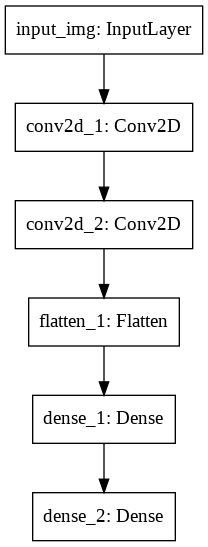

In [0]:
plot_model(model_initial, model_name+'/'+model_name+'.png')

In [0]:
model_initial.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 1)         28        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               6422656   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 6,424,614
Trainable params: 6,424,614
Non-trainable params: 0
_________________________________________________

#### Task 1.5 Training model
In order to train the model, instead of "model.fit" function, we will use the "model.fit_generator" function for training. For details check out [keras documentation](https://keras.io/models/sequential/)

In [0]:
class LRTensorBoard(TensorBoard):
    def __init__(self, *args, **kwargs):
        super(LRTensorBoard, self).__init__(*args, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        logs.update({'lr': K.eval(self.model.optimizer.lr)})
        super(LRTensorBoard, self).on_epoch_end(epoch, logs)

In [0]:
# Add the following callbacks to your Model: ModelCheckpoin, CSVLogger, ReduceLROnPlateau. The callback for Tensorboard has already been provided to you.
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
csvlogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001, min_delta=0.03)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, csvlogger, reducelr]

#### Task 1.5.1 
Train model without using any pre-processing scheme

In [0]:
# Create three generators: For training your model, for validation, for testing.
train_gen = data_generator(train_files , batch_size)
val_gen = data_generator(val_files, batch_size)
test_gen = data_generator(test_files, batch_size)


In [0]:
# Start training your model here
esteps = len(train_files)//batch_size
vsteps = len(val_files)//batch_size

hist_initial =  model_initial.fit_generator(train_gen, epochs=epochs, steps_per_epoch=esteps,
                           validation_data = val_gen, validation_steps = vsteps,
                           callbacks=callbacks, verbose=1)
all_histories.append(hist_initial)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










Epoch 1/25
781/781 [==============================] - 160s 205ms/step - loss: 14.4918 - acc: 0.1000 - val_loss: 14.4440 - val_acc: 0.1039

Epoch 00001: val_loss improved from inf to 14.44397, saving model to base_model/base_model-01-14.44.h5

Epoch 2/25
781/781 [==============================] - 157s 202ms/step - loss: 14.5061 - acc: 0.1000 - val_loss: 14.4440 - val_acc: 0.1039

Epoch 00002: val_loss did not improve from 14.44397
Epoch 3/25
781/781 [==============================] - 157s 201ms/step - loss: 14.5061 - acc: 0.1000 - val_loss: 14.4440 - val_acc: 0.1039

Epoch 00003: val_loss did not improve from 14.44397
Epoch 4/25
781/781 [==============================] - 157s 201ms/step - loss: 14.5061 - acc: 0.1000 - val_loss: 14.4440 - val_acc: 0.1039

Epoch 00004: val_loss did not improve from 14.44397
Epoch 5/25
781/781 [==============================] - 157s 201ms/step - loss: 14

#### Task 1.5.2 
Train model by using data preprocessing i.e normalization or mean shift. 

In [0]:
input_img = Input(shape=(input_shape_cifar), name='input_img')
l = Conv2D(1, kernel_size=(3,3), activation='relu')(input_img)
l = Conv2D(64, (3, 3), activation='tanh')(l)
# When shifting from Convolutional layers to dense layers, we need to Flatten out the 2D matrices into a 1D array
l = Flatten()(l)
l = Dense(128, activation='relu')(l)
output_class = Dense(num_classes, activation='softmax')(l)
model_preprocessed = Model(inputs=input_img, outputs=output_class)

In [0]:
model_name = 'model_preprocessed_input'

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    

In [0]:
# You may tweak this Learning Rate
adam = Adam(lr=0.0001)

# Compile your model using an appropriate loss
model_preprocessed.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

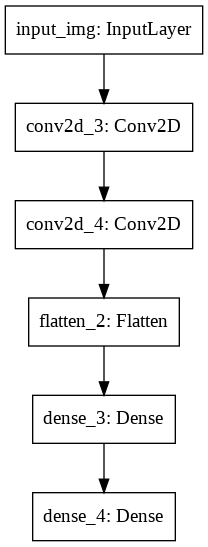

In [0]:
plot_model(model_preprocessed, model_name+'/'+model_name+'.png')

In [0]:
model_preprocessed.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 1)         28        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               6422656   
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 6,424,614
Trainable params: 6,424,614
Non-trainable params: 0
_________________________________________________

In [0]:
# Add the following callbacks: ModelCheckpoint, CSVLogger. The callback for tensorboard has been provided to you.
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
csvlogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001, min_delta=0.03)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, csvlogger, reducelr]

In [0]:
train_gen = data_generator(train_files , batch_size, preprocessing = preprocessing_norm)
val_gen = data_generator(val_files, batch_size, preprocessing = preprocessing_norm)
test_gen = data_generator(test_files, batch_size, preprocessing = preprocessing_norm)

In [0]:
esteps = len(train_files)//batch_size
vsteps = len(val_files)//batch_size
hist_preprocessed = model_preprocessed.fit_generator(train_gen, epochs=epochs, steps_per_epoch=esteps,
                           validation_data = val_gen, validation_steps = vsteps,
                           callbacks=callbacks, verbose=1)
all_histories.append(hist_preprocessed)

Epoch 1/25
781/781 [==============================] - 162s 207ms/step - loss: 2.0607 - acc: 0.2596 - val_loss: 1.9215 - val_acc: 0.3248

Epoch 00001: val_loss improved from inf to 1.92148, saving model to model_preprocessed_input/model_preprocessed_input-01-1.92.h5
Epoch 2/25
781/781 [==============================] - 161s 206ms/step - loss: 1.8750 - acc: 0.3360 - val_loss: 1.7848 - val_acc: 0.3798

Epoch 00002: val_loss improved from 1.92148 to 1.78485, saving model to model_preprocessed_input/model_preprocessed_input-02-1.78.h5
Epoch 3/25
781/781 [==============================] - 159s 204ms/step - loss: 1.7577 - acc: 0.3865 - val_loss: 1.6661 - val_acc: 0.4227

Epoch 00003: val_loss improved from 1.78485 to 1.66610, saving model to model_preprocessed_input/model_preprocessed_input-03-1.67.h5
Epoch 4/25
781/781 [==============================] - 159s 204ms/step - loss: 1.6596 - acc: 0.4243 - val_loss: 1.5708 - val_acc: 0.4606

Epoch 00004: val_loss improved from 1.66610 to 1.57077, s

### Task 2.1 Pooling
Now, you need to modify the model by adding pooling layer(s). Pooling could be average pooling or max pooling. You can use the size and stride for pooling of your choice. 
<br> 
Modify the network by introducing pooling layer and train the model using the __fit_generator__ function. 

In [0]:
model_name = 'model_pooling'

input_img = Input(shape=(input_shape_cifar), name='input_img')
l = Conv2D(1, kernel_size=(3,3), activation='relu')(input_img)
l = Conv2D(64, (3, 3), activation='tanh')(l)
l = MaxPooling2D(pool_size=(2, 2))(l)
# When shifting from Convolutional layers to dense layers, we need to Flatten out the 2D matrices into a 1D array
l = Flatten()(l)
l = Dense(128, activation='relu')(l)
output_class = Dense(num_classes, activation='softmax')(l)

model_pooled = Model(inputs=input_img, outputs=output_class)

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

In [0]:
adam = Adam(lr=0.0001)
model_pooled.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

In [0]:
plot_model(model_pooled, model_name+'/'+model_name+'.png')
model_pooled.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 1)         28        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1605760   
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290

In [0]:
# Add the following callbacks: ModelCheckpoint, CSVLogger
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
csvlogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, csvlogger]

In [0]:
# Create generators
train_gen = data_generator(train_files , batch_size, preprocessing = preprocessing_norm)
val_gen = data_generator(val_files, batch_size, preprocessing = preprocessing_norm)
test_gen = data_generator(test_files, batch_size, preprocessing = preprocessing_norm)

In [0]:
esteps = len(train_files)//batch_size
vsteps = len(val_files)//batch_size

hist_pooled = model_pooled.fit_generator(train_gen, epochs=epochs, steps_per_epoch=esteps,
                           validation_data = val_gen, validation_steps = vsteps,
                           callbacks=callbacks, verbose=1)
all_histories.append(hist_pooled)

Epoch 1/25
781/781 [==============================] - 96s 123ms/step - loss: 2.3027 - acc: 0.0995 - val_loss: 2.3026 - val_acc: 0.1045

Epoch 00001: val_loss improved from inf to 2.30258, saving model to model_pooling/model_pooling-01-2.30.h5
Epoch 2/25
781/781 [==============================] - 97s 124ms/step - loss: 2.0319 - acc: 0.2423 - val_loss: 1.7444 - val_acc: 0.3806

Epoch 00002: val_loss improved from 2.30258 to 1.74444, saving model to model_pooling/model_pooling-02-1.74.h5
Epoch 3/25
781/781 [==============================] - 99s 127ms/step - loss: 1.6807 - acc: 0.4012 - val_loss: 1.5999 - val_acc: 0.4432

Epoch 00003: val_loss improved from 1.74444 to 1.59992, saving model to model_pooling/model_pooling-03-1.60.h5
Epoch 4/25
781/781 [==============================] - 99s 127ms/step - loss: 1.5750 - acc: 0.4455 - val_loss: 1.5111 - val_acc: 0.4789

Epoch 00004: val_loss improved from 1.59992 to 1.51110, saving model to model_pooling/model_pooling-04-1.51.h5
Epoch 5/25
781/7

### Task 3.1 Dropout
Modify the network by introducing dropout layer(s) and train the model using the __fit_generator__ function. 

In [0]:
model_name = 'model_dropout'

input_img = Input(shape=(input_shape_cifar), name='input_img')
l = Conv2D(1, kernel_size=(3,3), activation='relu')(input_img)
l = Conv2D(64, (3, 3), activation='tanh')(l)
l = MaxPooling2D(pool_size=(2, 2))(l)
l = Dropout(rate=0.25)(l)
# When shifting from Convolutional layers to dense layers, we need to Flatten out the 2D matrices into a 1D array
l = Flatten()(l)
l = Dense(128, activation='relu')(l)
l = Dropout(rate=0.5)(l)
output_class = Dense(num_classes, activation='softmax')(l)

model_dropout = Model(inputs=input_img, outputs=output_class)

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
adam = Adam(lr=0.0001)
model_dropout.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

In [0]:
plot_model(model_dropout, model_name+'/'+model_name+'.png')
model_dropout.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 1)         28        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               1605

In [0]:
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
csvlogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, csvlogger]

In [0]:
# Create three Generators
train_gen = data_generator(train_files , batch_size, preprocessing = preprocessing_norm)
val_gen = data_generator(val_files, batch_size, preprocessing = preprocessing_norm)
test_gen = data_generator(test_files, batch_size, preprocessing = preprocessing_norm)

In [0]:
esteps = len(train_files)//batch_size
vsteps = len(val_files)//batch_size

hist_dropout = model_dropout.fit_generator(train_gen, epochs=epochs, steps_per_epoch=esteps,
                           validation_data = val_gen, validation_steps = vsteps,
                           callbacks=callbacks, verbose=1)

all_histories.append(hist_dropout)

Epoch 1/25
781/781 [==============================] - 104s 133ms/step - loss: 2.0933 - acc: 0.2287 - val_loss: 1.8710 - val_acc: 0.3348

Epoch 00001: val_loss improved from inf to 1.87097, saving model to model_dropout/model_dropout-01-1.87.h5
Epoch 2/25
781/781 [==============================] - 105s 134ms/step - loss: 1.8650 - acc: 0.3356 - val_loss: 1.7489 - val_acc: 0.3957

Epoch 00002: val_loss improved from 1.87097 to 1.74890, saving model to model_dropout/model_dropout-02-1.75.h5
Epoch 3/25
781/781 [==============================] - 108s 138ms/step - loss: 1.7633 - acc: 0.3740 - val_loss: 1.6388 - val_acc: 0.4406

Epoch 00003: val_loss improved from 1.74890 to 1.63880, saving model to model_dropout/model_dropout-03-1.64.h5
Epoch 4/25
781/781 [==============================] - 105s 134ms/step - loss: 1.6740 - acc: 0.4076 - val_loss: 1.5508 - val_acc: 0.4729

Epoch 00004: val_loss improved from 1.63880 to 1.55082, saving model to model_dropout/model_dropout-04-1.55.h5
Epoch 5/25
7

### Task 4.1 Batch Normalization
Modify the network by introducing batch normalization layer(s) and train the model. 

In [0]:
model_name = 'model_batch_normalized'
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

In [0]:
input_img = Input(shape=(input_shape_cifar), name='input_img')
l = Conv2D(1, kernel_size=(3,3), activation='relu')(input_img)
l = BatchNormalization()(l)
l = Conv2D(64, (3, 3), activation='tanh')(l)
l = MaxPooling2D(pool_size=(2, 2))(l)
l = Dropout(rate=0.25)(l)
# When shifting from Convolutional layers to dense layers, we need to Flatten out the 2D matrices into a 1D array
l = Flatten()(l)
l = BatchNormalization()(l)
l = Dense(128, activation='relu')(l)
l = Dropout(rate=0.5)(l)
output_class = Dense(num_classes, activation='softmax')(l)
model_normalized = Model(inputs=input_img, outputs=output_class)

In [0]:
adam = Adam(lr=0.0001)
model_normalized.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

In [0]:
plot_model(model_normalized, model_name+'/'+model_name+'.png')
model_normalized.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 30, 1)         28        
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 1)         4         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 12544)             0   

In [0]:
# Add the following checkpoints: ModelCheckpoint, CSVLogger
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
csvlogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, csvlogger]

In [0]:
# Create three generators
train_gen = data_generator(train_files , batch_size, preprocessing = preprocessing_norm)
val_gen = data_generator(val_files, batch_size, preprocessing = preprocessing_norm)
test_gen = data_generator(test_files, batch_size, preprocessing = preprocessing_norm)

In [0]:
esteps = len(train_files)//batch_size
vsteps = len(val_files)//batch_size
hist_normalized = model_normalized.fit_generator(train_gen, epochs=epochs, steps_per_epoch=esteps,
                           validation_data = val_gen, validation_steps = vsteps,
                           callbacks=callbacks, verbose=1)
all_histories.append(hist_normalized)

Epoch 1/25
1562/1562 [==============================] - 139s 89ms/step - loss: 2.1950 - acc: 0.3023 - val_loss: 1.4572 - val_acc: 0.5035

Epoch 00001: val_loss improved from inf to 1.45715, saving model to model_batch_normalized/model_batch_normalized-01-1.46.h5
Epoch 2/25
1562/1562 [==============================] - 138s 89ms/step - loss: 1.7002 - acc: 0.4110 - val_loss: 1.2738 - val_acc: 0.5743

Epoch 00002: val_loss improved from 1.45715 to 1.27384, saving model to model_batch_normalized/model_batch_normalized-02-1.27.h5
Epoch 3/25
1562/1562 [==============================] - 139s 89ms/step - loss: 1.5319 - acc: 0.4649 - val_loss: 1.1882 - val_acc: 0.6057

Epoch 00003: val_loss improved from 1.27384 to 1.18817, saving model to model_batch_normalized/model_batch_normalized-03-1.19.h5
Epoch 4/25
1562/1562 [==============================] - 139s 89ms/step - loss: 1.4253 - acc: 0.5026 - val_loss: 1.0687 - val_acc: 0.6484

Epoch 00004: val_loss improved from 1.18817 to 1.06874, saving mo

### Task 5.1 Comparison of all models
In this task you need to plot the loss and accuracy for all models and __discuss__ which model has better performance and why do you think so.

In [0]:
# Plot accuracy of all models
def plotHistory(histories, names, metric):
    plt.clf() 
    x_axis = list(range(epochs))
    for hist, name in zip(histories, names):
        plt.plot(x_axis, hist.history[metric], label=metric+'_'+name)
        plt.scatter(x_axis, hist.history[metric])
    plt.legend()
    plt.title(metric)
    plt.show()

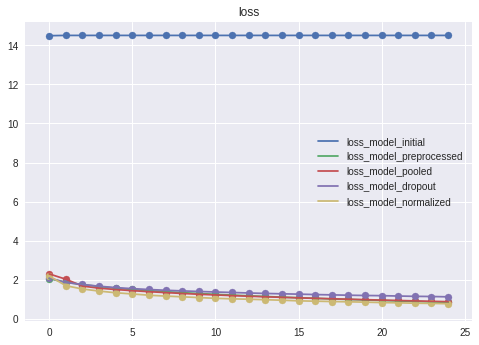

In [0]:
# Plot histories of all models
mnames = ['model_initial','model_preprocessed','model_pooled','model_dropout','model_normalized']
plotHistory(all_histories, mnames ,'loss')

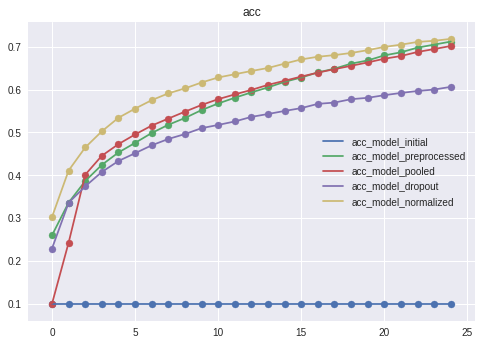

In [0]:
# Plot histories of all models
mnames = ['model_initial','model_preprocessed','model_pooled','model_dropout','model_normalized']
plotHistory(all_histories, mnames ,'acc')

In [0]:
#ANALYSIS
#the normalized model has the best performance. This could be because batch normalization 
#regularizes the model. Regularization reduces overfitting which improves accuracy by generalising the model.
# Preprocessing using normalization significantly increases accuracy.

#### Tensorboard 
We will be covering Tensorboard in Friday's tutorial. You can complete this part after the tutorial (21st Feb 2020)

In [70]:
!tensorboard --logdir='/content/drive/My Drive/base_model' --host='8da5507721cb'

TensorBoard 1.15.0 at http://8da5507721cb:6006/ (Press CTRL+C to quit)
^C


You can run TensorBoard using the following command

> Indented block


```tensorboard --logdir=path/to/log-directory
```
Now for logs of all above trained models, take snapshot of the _loss_ and _accuracy_ plots and save in the directory where this notebook is. To show that saved plot here in notebook use following command in _markdown_ cell. 
<br> __![](path_to_image)__

**Add cells to include loss plots**

##### Add your analysis here

### Task 5.2 Visualize Activations
We will be covering this in Friday's tutorial. You can complete this part after the tutorial (21st Feb 2020). In this task, you are required to visualize the activations (outputs) of both the convolution layers of a model.

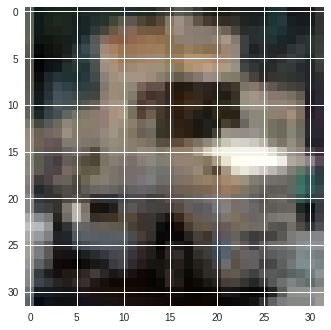

In [76]:
# Load any image here
test_image = cv2.imread(test_files[2])
plt.imshow(test_image)

array([9])

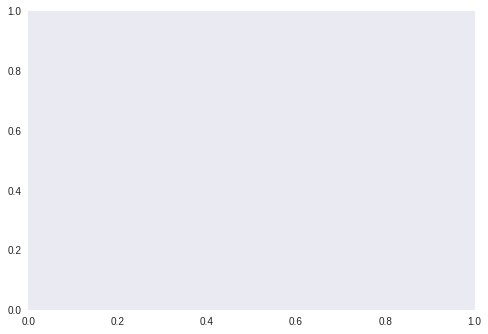

In [83]:
plt.gca().grid(False);
test_reshaped = test_image.reshape((1,32,32,3))
model_preprocessed.predict(test_reshaped).argmax(axis=1)
# Get a prediction from ANY ONE of your models and output its label

In [0]:
# Create a Model from the Input layer to a Convolutional Layer
new_model = Model(inputs=model_preprocessed.get_layer('input_img').input,
                  outputs=model_preprocessed.get_layer('conv2d_3').output)

In [137]:
# Get a prediction for your chosen image using this model
predicted_activations = new_model.predict(test_reshaped)
predicted_activations.shape

(1, 30, 30, 1)

IndexError: ignored

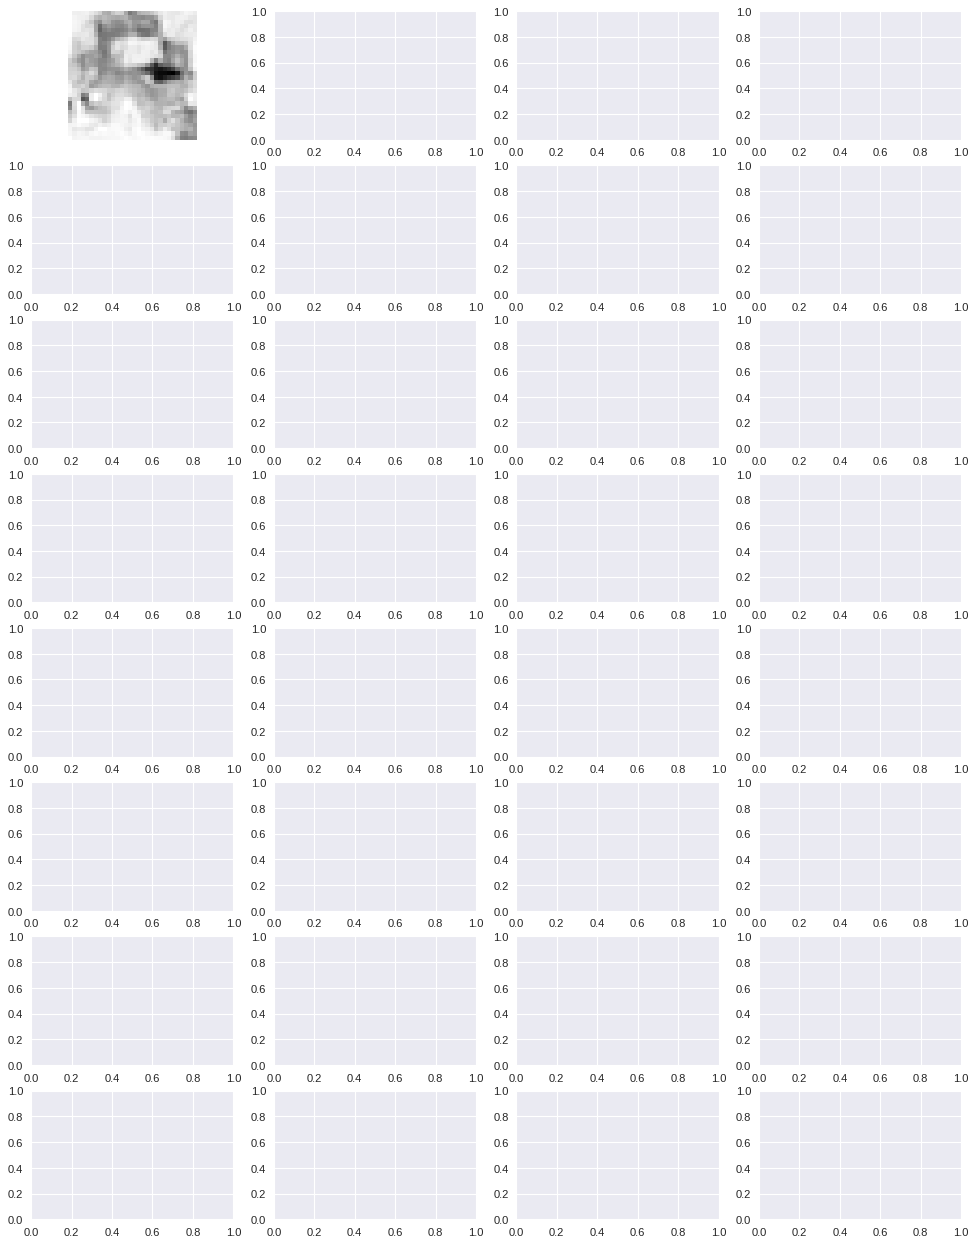

In [141]:
# Use your predictions to visualise the activations
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(15,20), dpi=80)

for i,ax in enumerate(axes.flatten()):
    ax.imshow(predicted_activations[0,:,:,i]);
    ax.grid(False);
    ax.axis('off');

In [0]:
# Create another model to visualize activations from ANOTHER convolutional layer

In [0]:
# You may rename this variable
second_predicted_activations = None

In [0]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15,15), dpi=80)
for i,ax in enumerate(axes.flatten()):
    ax.imshow(second_predicted_activations[0,:,:,i]);
    ax.grid(False);
    ax.axis('off');

Q) What features from your chosen image do you think your model has been able to learn? In terms of filters (weights), what goes on when we add more convolutional layers in our models?

### Task 6.1  Effect of learning rate
Take the best selected model in __Task 5.1__ and change its learning rate to: 
- 6.1.1 any value between 5 and 1.
- 6.1.2 learning rate = any value between 0.6 and  0.1 
- 6.1.3 learning rate = 0.00001

and train these three models to compare the effect learning rate.

In [0]:
# Use code provided in previous tasks
6.1.1


In [0]:
model_name = 'model_batch_normalized2'
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

In [0]:
input_img = Input(shape=(input_shape_cifar), name='input_img')
l = Conv2D(1, kernel_size=(3,3), activation='relu')(input_img)
l = BatchNormalization()(l)
l = Conv2D(64, (3, 3), activation='tanh')(l)
l = MaxPooling2D(pool_size=(2, 2))(l)
l = Dropout(rate=0.25)(l)
# When shifting from Convolutional layers to dense layers, we need to Flatten out the 2D matrices into a 1D array
l = Flatten()(l)
l = BatchNormalization()(l)
l = Dense(128, activation='relu')(l)
l = Dropout(rate=0.5)(l)
output_class = Dense(num_classes, activation='softmax')(l)
model_normalized2 = Model(inputs=input_img, outputs=output_class)

In [0]:
adam = Adam(lr=3)
model_normalized2.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

In [0]:
# Add the following checkpoints: ModelCheckpoint, CSVLogger
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
csvlogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, csvlogger]

In [0]:
# Create three generators
train_gen = data_generator(train_files , batch_size, preprocessing = preprocessing_norm)
val_gen = data_generator(val_files, batch_size, preprocessing = preprocessing_norm)
test_gen = data_generator(test_files, batch_size, preprocessing = preprocessing_norm)

In [107]:
esteps = len(train_files)//batch_size
vsteps = len(val_files)//batch_size
hist_normalized2 = model_normalized2.fit_generator(train_gen, epochs=epochs, steps_per_epoch=esteps,
                           validation_data = val_gen, validation_steps = vsteps,
                           callbacks=callbacks, verbose=1)
#all_histories.append(hist_normalized)

Epoch 1/25
1562/1562 [==============================] - 142s 91ms/step - loss: 0.7624 - acc: 0.7254 - val_loss: 0.4420 - val_acc: 0.8714

Epoch 00001: val_loss improved from inf to 0.44199, saving model to model_batch_normalized2/model_batch_normalized2-01-0.44.h5
Epoch 2/25
1562/1562 [==============================] - 142s 91ms/step - loss: 0.7567 - acc: 0.7286 - val_loss: 0.4251 - val_acc: 0.8842

Epoch 00002: val_loss improved from 0.44199 to 0.42507, saving model to model_batch_normalized2/model_batch_normalized2-02-0.43.h5
Epoch 3/25
1562/1562 [==============================] - 142s 91ms/step - loss: 0.7386 - acc: 0.7346 - val_loss: 0.4116 - val_acc: 0.8830

Epoch 00003: val_loss improved from 0.42507 to 0.41164, saving model to model_batch_normalized2/model_batch_normalized2-03-0.41.h5
Epoch 4/25
1562/1562 [==============================] - 142s 91ms/step - loss: 0.7347 - acc: 0.7341 - val_loss: 0.4071 - val_acc: 0.8890

Epoch 00004: val_loss improved from 0.41164 to 0.40711, sav

In [0]:
model_name = 'model_batch_normalized4'
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

In [0]:
input_img = Input(shape=(input_shape_cifar), name='input_img')
l = Conv2D(1, kernel_size=(3,3), activation='relu')(input_img)
l = BatchNormalization()(l)
l = Conv2D(64, (3, 3), activation='tanh')(l)
l = MaxPooling2D(pool_size=(2, 2))(l)
l = Dropout(rate=0.25)(l)
# When shifting from Convolutional layers to dense layers, we need to Flatten out the 2D matrices into a 1D array
l = Flatten()(l)
l = BatchNormalization()(l)
l = Dense(128, activation='relu')(l)
l = Dropout(rate=0.5)(l)
output_class = Dense(num_classes, activation='softmax')(l)
model_normalized4 = Model(inputs=input_img, outputs=output_class)

In [0]:
adam = Adam(lr=0.00001)
model_normalized4.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

In [0]:
# Add the following checkpoints: ModelCheckpoint, CSVLogger
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
csvlogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, csvlogger]

In [0]:
# Create three generators
train_gen = data_generator(train_files , batch_size, preprocessing = preprocessing_norm)
val_gen = data_generator(val_files, batch_size, preprocessing = preprocessing_norm)
test_gen = data_generator(test_files, batch_size, preprocessing = preprocessing_norm)

In [0]:
esteps = len(train_files)//batch_size
vsteps = len(val_files)//batch_size
hist_normalized4 = model_normalized4.fit_generator(train_gen, epochs=epochs, steps_per_epoch=esteps,
                           validation_data = val_gen, validation_steps = vsteps,
                           callbacks=callbacks, verbose=1)
#all_histories.append(hist_normalized)

Epoch 1/25
1562/1562 [==============================] - 142s 91ms/step - loss: 2.5869 - acc: 0.1960 - val_loss: 1.8428 - val_acc: 0.3482

Epoch 00001: val_loss improved from inf to 1.84282, saving model to model_batch_normalized4/model_batch_normalized4-01-1.84.h5
Epoch 2/25
1562/1562 [==============================] - 143s 91ms/step - loss: 2.2755 - acc: 0.2568 - val_loss: 1.7294 - val_acc: 0.3980

Epoch 00002: val_loss improved from 1.84282 to 1.72941, saving model to model_batch_normalized4/model_batch_normalized4-02-1.73.h5
Epoch 3/25
1562/1562 [==============================] - 145s 93ms/step - loss: 2.1363 - acc: 0.2868 - val_loss: 1.6464 - val_acc: 0.4270

Epoch 00003: val_loss improved from 1.72941 to 1.64644, saving model to model_batch_normalized4/model_batch_normalized4-03-1.65.h5
Epoch 4/25
1562/1562 [==============================] - 145s 93ms/step - loss: 2.0372 - acc: 0.3116 - val_loss: 1.5889 - val_acc: 0.4552

Epoch 00004: val_loss improved from 1.64644 to 1.58894, sav

### Task 6.2 Plot loss and accuracy
Plot the loss and accracy for best model selected in task 5.1, and model trained in 6.1.1, 6.1.2 and 6.1.3 task. Give the detailed analysis of the effect of learning rate in your words and select the best learning rate for this problem.

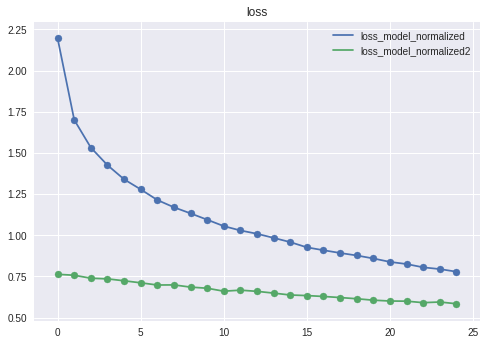

In [114]:
hists = [hist_normalized,hist_normalized2,histnormalized_4]
names = ['model_normalized','model_normalized2','histnormalized_4']
plotHistory(hists, names,'loss')

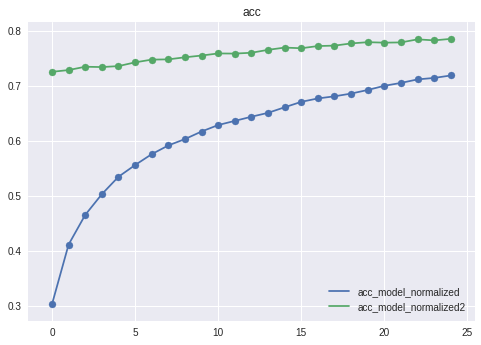

In [115]:
plotHistory(hists,names,'acc')

Analysis: a very high learning rate overshoots accuracy.Lowering the learning rate from 0.001 to 0.0001 increases accuracy